### IMPORTS ET CONFIGURATION

In [3]:
# Import des bibliothèques
# et des fonctions personnalisées définies dans my_function.py
import sys
sys.path.append("/home/onyxia/work")

import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from osgeo import gdal, ogr
from libsigma import read_and_write as rw

from my_function import (
    create_stack, 
    rasterize_vector,
    extract_stats_by_class,
    calculate_ari,
    save_raster,
    save_multiband_raster,
    prepare_training_data
)
import sys
sys.path.append("/home/onyxia/work")

import my_function as mf


### Définition des chemins

In [4]:
# Définition des chemins de travail
BASE = "/home/onyxia/work"
DATA = BASE + "/data/projet_eval"
RESULTS = BASE + "/results"
FIG = RESULTS + "/figure"

# Création des dossiers de sortie
os.makedirs(RESULTS, exist_ok=True)
os.makedirs(FIG, exist_ok=True)

# Fichiers d'entrée
vector_samples = DATA + "/PI_strates_bretagne_32630.shp"
ref_image = DATA + "/bretagne_24-25_B03.tif"


# PARTIE 1 - ANALYSE DES ÉCHANTILLONS

### Lecture des polygones d'échantillons

In [5]:
gdf = gpd.read_file(vector_samples)
print(gdf.head())


   id  strate      comment                                           geometry
0   1       3  lande basse  POLYGON ((441224.58 5366298.317, 441224.779 53...
1   2       3  lande basse  POLYGON ((441649.972 5366251.139, 441650.172 5...
2   3       3  lande basse  POLYGON ((441383.597 5366193.034, 441384.395 5...
3   4       2         None  POLYGON ((441336.658 5366402.088, 441337.257 5...
4   5       2         None  POLYGON ((441062.121 5366343.165, 441062.919 5...


### Comptage des polygones par classe

In [6]:
counts_poly = gdf["strate"].value_counts().sort_index()
print("\nNombre de polygones par classe :")
print(counts_poly)


Nombre de polygones par classe :
strate
2     86
3    121
4     71
Name: count, dtype: int64


### Création du diagramme en bâtons - Polygones

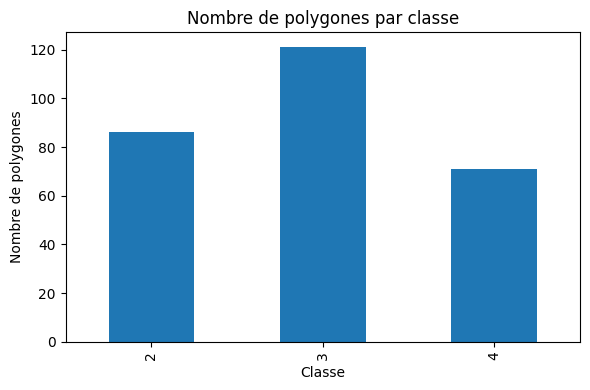

In [7]:
plt.figure(figsize=(6,4))
counts_poly.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.tight_layout()
plt.savefig(FIG + "/diag_baton_nb_poly_by_class.png", dpi=150)
plt.show()

###  Note sur la nomenclature

Analyse des polygones d’échantillons

Le diagramme en bâtons met en évidence la présence de trois classes seulement dans les échantillons disponibles :
– classe 2 (Herbe),
– classe 3 (Landes),
– classe 4 (Arbre).

La classe 1 (Sol Nu) est absente de la base d’échantillons. Cette absence est cohérente avec le contexte breton, caractérisé par une forte couverture végétale permanente et peu de surfaces minérales nues.

En conséquence, la classification supervisée sera limitée à ces trois classes, et aucune prédiction de la classe Sol Nu ne sera possible.

#  PARTIE 2 — RASTERISATION DES ÉCHANTILLONS

###  Rasterisation à 10m de résolution

In [8]:
out_raster = RESULTS + "/strates_rasterise.tif"

ds_ref = gdal.Open(ref_image)
gt = ds_ref.GetGeoTransform()
proj = ds_ref.GetProjection()
cols = ds_ref.RasterXSize
rows = ds_ref.RasterYSize

driver = gdal.GetDriverByName("GTiff")
ds_out = driver.Create(out_raster, cols, rows, 1, gdal.GDT_Byte)
ds_out.SetGeoTransform(gt)
ds_out.SetProjection(proj)

band = ds_out.GetRasterBand(1)
band.SetNoDataValue(0)
band.Fill(0)

ds_vect = ogr.Open(vector_samples)
layer = ds_vect.GetLayer()

gdal.RasterizeLayer(ds_out, [1], layer, options=["ATTRIBUTE=strate"])

ds_out = None
ds_ref = None
ds_vect = None

print("Raster des strates créé")


Raster des strates créé


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Les polygones d’échantillons sont rasterisés à la résolution spatiale de 10 m, en utilisant la bande B03 comme image de référence pour garantir la cohérence géométrique (projection, emprise et taille de pixel).
Les pixels non échantillonnés sont codés à 0 (nodata).

### Comptage des pixels par classe

In [9]:
arr = rw.load_img_as_array(out_raster).squeeze()
vals, counts = np.unique(arr[arr > 0], return_counts=True)

print("\nNombre de pixels par classe :")
for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")



Nombre de pixels par classe :
Classe 2 : 1022 pixels
Classe 3 : 1599 pixels
Classe 4 : 1218 pixels


### Création du diagramme en bâtons - Pixels

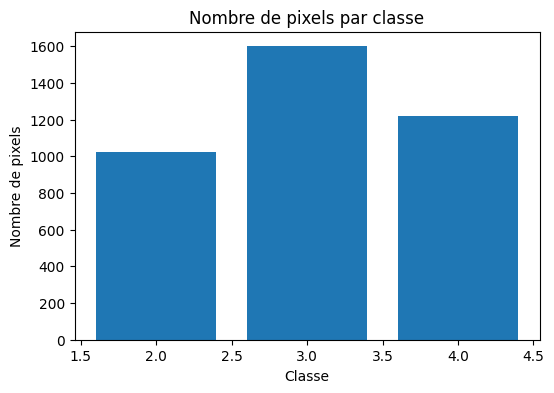

In [10]:
plt.figure(figsize=(6,4))
plt.bar(vals, counts)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.savefig(FIG + "/diag_baton_nb_pix_by_class.png", dpi=150)
plt.show()


Les classes ne sont pas parfaitement équilibrées en nombre de pixels. La classe Landes est la plus représentée, ce qui pourra influencer l’apprentissage du classifieur supervisé et justifie l’utilisation d’une métrique pondérée lors de l’optimisation.

# PARTIE 3A - CALCUL DE L'INDICE ARI

### SÉLECTION DES BANDES B03 ET B05

In [11]:
# Les fichiers Sentinel-2 fournis sont déjà des séries temporelles :
# chaque bande du GeoTIFF correspond à une date de la série
stack_B03 = DATA + "/bretagne_24-25_B03.tif"
stack_B05 = DATA + "/bretagne_24-25_B05.tif"

# Chargement
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

print("Shape B03 :", B03.shape)
print("Shape B05 :", B05.shape)



Shape B03 : (612, 1533, 6)
Shape B05 : (612, 1533, 6)


Les bandes B03 (vert) et B05 (red-edge) sont utilisées pour le calcul de l’indice ARI.
La cohérence temporelle est vérifiée en contrôlant que le nombre de dates est identique pour les deux bandes.

### Chargement et calcul de l'ARI

In [12]:
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

np.seterr(divide="ignore", invalid="ignore")
ARI = (1.0/B03 - 1.0/B05) / (1.0/B03 + 1.0/B05)
ARI[np.isnan(ARI)] = -9999


### Sauvegarde de la série temporelle ARI

In [13]:
out_ARI = RESULTS + "/ARI_serie_temp.tif"
ds_ref = gdal.Open(stack_B03)
driver = gdal.GetDriverByName("GTiff")

rows, cols, nb_dates = ARI.shape

ds_out = driver.Create(out_ARI, cols, rows, nb_dates, gdal.GDT_Float32)
ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

for i in range(nb_dates):
    band = ds_out.GetRasterBand(i+1)
    band.WriteArray(ARI[:,:,i])
    band.SetNoDataValue(-9999)

ds_out = None
ds_ref = None

print("Série temporelle ARI sauvegardée")

Série temporelle ARI sauvegardée


# PARTIE 3B - ANALYSE PHÉNOLOGIQUE

### Extraction des statistiques par classe

In [14]:
# Extraction des statistiques ARI par classe

ARI_loaded = rw.load_img_as_array(out_ARI)
strates = rw.load_img_as_array(out_raster).squeeze()

classes = [2, 3, 4]  # Herbe, Landes, Arbre
nb_classes = len(classes)
nb_dates = ARI_loaded.shape[2]

# Initialisation des tableaux
moyennes = np.zeros((nb_classes, nb_dates))
ecarts_types = np.zeros((nb_classes, nb_dates))

# Calcul des statistiques
for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    for d in range(nb_dates):
        valeurs = ARI_loaded[:, :, d][mask_classe]
        valeurs = valeurs[valeurs != -9999]

        if valeurs.size > 0:
            moyennes[i, d] = np.mean(valeurs)
            ecarts_types[i, d] = np.std(valeurs)
        else:
            moyennes[i, d] = np.nan
            ecarts_types[i, d] = np.nan

print("Statistiques ARI calculées pour chaque classe et chaque date")


Statistiques ARI calculées pour chaque classe et chaque date


### Création du graphique de phénologie

La figure suivante présente l’évolution temporelle de l’indice ARI moyen par strate, ainsi que l’écart-type intra-classe. L’objectif est d’évaluer la capacité de l’ARI à discriminer la classe Landes.

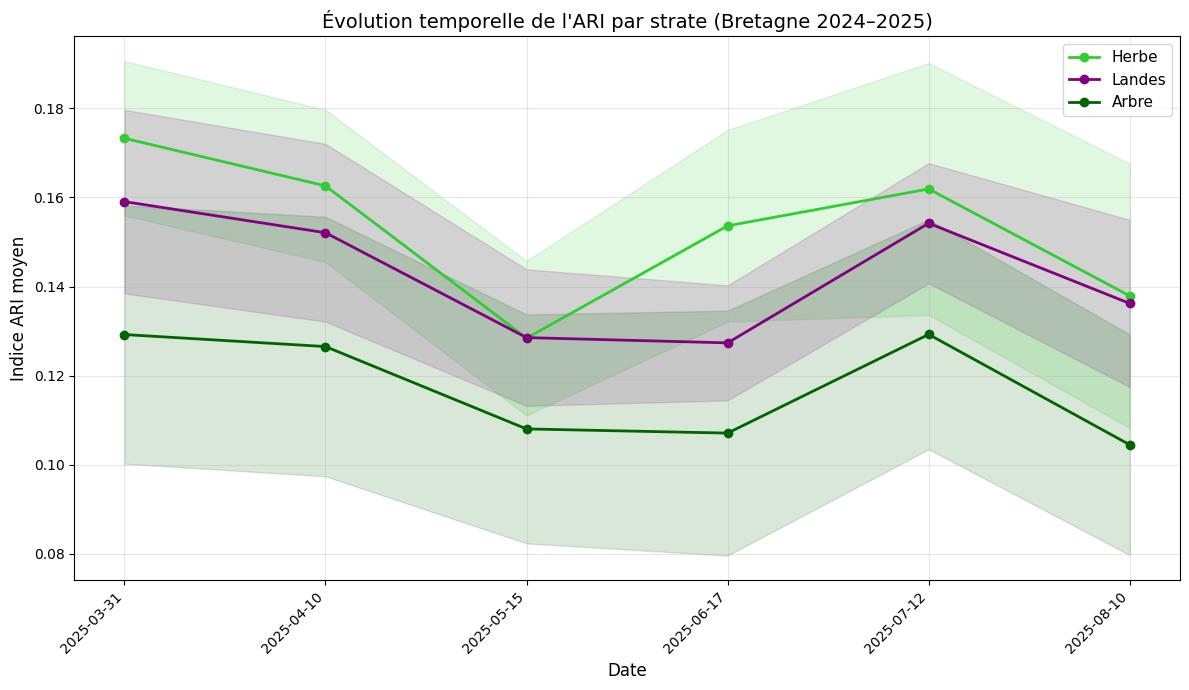

In [15]:
# Dates correspondant aux 6 acquisitions Sentinel-2 de la série Bretagne 2024–2025
dates = ["2025-03-31", "2025-04-10", "2025-05-15", 
         "2025-06-17", "2025-07-12", "2025-08-10"]

plt.figure(figsize=(12, 7))

labels = ["Herbe", "Landes", "Arbre"]
colors = ["limegreen", "purple", "darkgreen"]

for i in range(3):
    plt.plot(dates, moyennes[i, :],
             label=labels[i],
             color=colors[i],
             marker='o',
             linewidth=2,
             markersize=6)

    plt.fill_between(dates,
                     moyennes[i, :] - ecarts_types[i, :],
                     moyennes[i, :] + ecarts_types[i, :],
                     alpha=0.15,
                     color=colors[i])

plt.xlabel("Date", fontsize=12)
plt.ylabel("Indice ARI moyen", fontsize=12)
plt.title("Évolution temporelle de l'ARI par strate (Bretagne 2024–2025)", fontsize=14)
plt.legend(loc="best", fontsize=11)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG + "/ARI_series.png", dpi=150, bbox_inches="tight")
plt.show()

### Analyse de la phénologie ARI

Les valeurs moyennes de l’ARI varient globalement entre 0.10 et 0.18 pour l’ensemble des strates étudiées. Les écarts-types observés traduisent une variabilité intra-classe non négligeable, en particulier pour les classes Herbe et Landes.

La classe Herbe présente les valeurs d’ARI les plus élevées sur l’ensemble de la période, avec un maximum observé en été. La classe Landes montre un comportement temporel proche de celui de l’Herbe, avec des valeurs intermédiaires. À l’inverse, la classe Arbre présente des valeurs plus faibles et relativement plus stables dans le temps.

La classe Landes ne se distingue pas clairement des autres strates sur la base de l’ARI seul. La forte similarité de son profil temporel avec celui de l’Herbe suggère des confusions potentielles entre ces deux classes.

On observe une dynamique saisonnière marquée, avec un minimum au printemps (mai–juin) et un maximum en été (juillet), cohérente avec les cycles de végétation.

En conclusion, l’ARI seul ne permet pas une discrimination satisfaisante des Landes. Une approche multivariée intégrant l’ensemble des bandes spectrales et la dimension temporelle apparaît nécessaire pour améliorer la classification.

# PARTIE 4 - CLASSIFICATION SUPERVISÉE

### Fusion des images mono bandes en une seule image multi bande

In [16]:
directory = "/home/onyxia/work/data/projet_eval/"
extension = ".tif"

files = [
    os.path.join(directory, f)
    for f in os.listdir(directory)
    if f.startswith("bretagne_24-25_") and f.endswith(extension)
]

files.sort()  # IMPORTANT : ordre stable (bandes/dates)

print("Nombre d'images fusionnées :", len(files))

images = []

for path in files:
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)

    # Lecture + conversion float32
    arr = band.ReadAsArray().astype(np.float32)

    # Gestion du nodata
    nodata = band.GetNoDataValue()
    if nodata is not None:
        arr[arr == nodata] = -9999

    images.append(arr)
    ds = None

output_multibande = "/home/onyxia/work/results/image_multibande_bretagne.tif"

ref_raster = os.path.join(directory, "bretagne_24-25_B03.tif")

mf.merge_and_save_multiband(
    images=images,
    output_path=output_multibande,
    reference_raster_path=ref_raster,
    nodata=-9999
)


print("✅ Image multibande créée :", output_multibande)


Nombre d'images fusionnées : 10
✅ Image multibande créée : /home/onyxia/work/results/image_multibande_bretagne.tif
✅ Image multibande créée : /home/onyxia/work/results/image_multibande_bretagne.tif


In [17]:
ds = gdal.Open(output_multibande)

print("Nombre de bandes :", ds.RasterCount)

for i in range(1, ds.RasterCount + 1):
    arr = ds.GetRasterBand(i).ReadAsArray()
    print(f"Bande {i}: min={np.nanmin(arr):.3f} max={np.nanmax(arr):.3f} mean={np.nanmean(arr):.3f}")

ds = None


Nombre de bandes : 10
Bande 1: min=1040.000 max=5144.000 mean=1398.158
Bande 2: min=1091.000 max=5332.000 mean=1655.757
Bande 3: min=1074.000 max=5340.000 mean=1656.484
Bande 4: min=1126.000 max=4638.000 mean=2250.318
Bande 5: min=1111.000 max=6170.000 mean=3401.843
Bande 6: min=1148.000 max=7445.000 mean=3778.360
Bande 7: min=1186.000 max=7900.000 mean=4114.410
Bande 8: min=1211.000 max=5621.000 mean=3323.119
Bande 9: min=1126.000 max=4574.000 mean=2315.453
Bande 10: min=1142.000 max=7661.000 mean=4126.927


### Production d’une carte de strates à l’échelle du pixel

In [18]:
mon_dossier = "/home/onyxia/work"

multi_band_image = "/home/onyxia/work/results/image_multibande_bretagne.tif"
sample_image_raster = os.path.join(RESULTS, "strates_rasterise.tif")

# Sample parameters
#test_size = 0.7
nb_iter = 5
nb_folds = 5
is_point = False # if is_point is True

field_name = "strate"

suffix = f"_CV{nb_folds}fold_stratified_x{nb_iter}times"

sortie_classif = os.path.join(RESULTS, "carte_strates_RF.tif")
sortie_matrix = os.path.join(RESULTS, f"ma_matrice{suffix}.png")
sortie_qualite = os.path.join(RESULTS, f"mes_qualites{suffix}.png")



### Extraction des échantillons d'entraînement

In [19]:
X_stack = rw.load_img_as_array(multi_band_image).astype(np.float32)
y_raster = rw.load_img_as_array(sample_image_raster).squeeze()

X, Y, mask = prepare_training_data(X_stack, y_raster)

print(X.shape)
print(Y.shape)


(3839, 10)
(3839,)


### Validation croisée

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold

kf = RepeatedStratifiedKFold(
    n_splits=nb_folds,
    n_repeats=nb_iter,
    random_state=42
)

list_cm = []
list_accuracy = []
list_report = []


### GridSearch

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=0, n_jobs=-1)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None, "sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=2
)

print("🚀 GridSearch global en cours...")
grid.fit(X, Y)

best_model = grid.best_estimator_

print("✅ Meilleurs paramètres :", grid.best_params_)
print("✅ Score CV global :", grid.best_score_)


🚀 GridSearch global en cours...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   2.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   3.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=   4.2s
[

### Validation croisée

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

list_cm = []
list_acc = []

for train_idx, test_idx in cv.split(X, Y):

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    best_model.fit(X_train, Y_train)
    Y_pred = best_model.predict(X_test)

    list_cm.append(confusion_matrix(Y_test, Y_pred))
    list_acc.append(accuracy_score(Y_test, Y_pred))


### Importance des variables

,Variable,Importance
0,bretagne_B02,0.035342
1,bretagne_B03,0.040179
2,bretagne_B04,0.128907
3,bretagne_B05,0.086030
4,bretagne_B06,0.151171
5,bretagne_B07,0.150274
6,bretagne_B08,0.119392
7,bretagne_B8A,0.121131
8,bretagne_B11,0.081208
9,bretagne_B12,0.086367


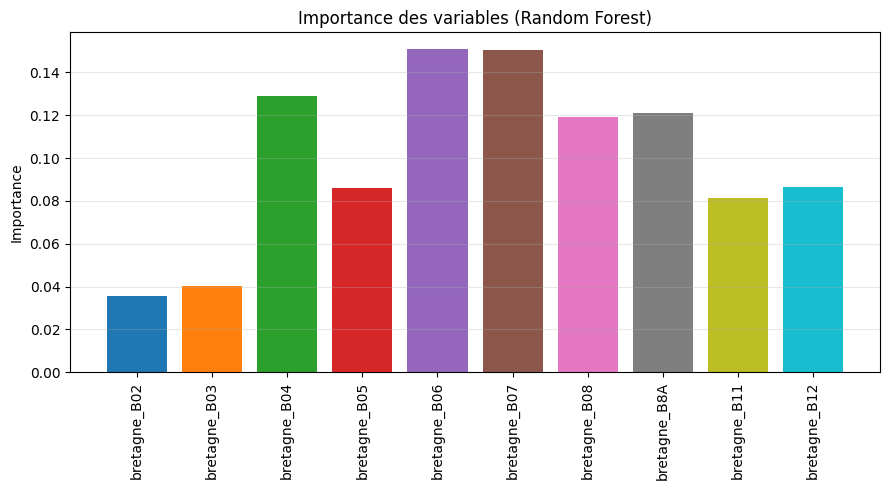

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

importances = best_model.feature_importances_

bandes_classif = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
feature_names = [f"bretagne_{b}" for b in bandes_classif]

df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})

display(df_imp)

# Palette de 10 couleurs distinctes
colors = cm.tab10.colors

plt.figure(figsize=(9, 5))
plt.bar(
    df_imp["Variable"],
    df_imp["Importance"],
    color=colors[:len(df_imp)]
)

plt.xticks(rotation=90)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



### Exactitude globale moyenne + écart-type

In [52]:
list_report = []

...

report = classification_report(Y_test, Y_pred, output_dict=True)
list_report.append(mf.report_from_dict_to_df(report))


In [53]:
array_report = np.array(list_report)

mean_report = array_report.mean(axis=0)
std_report  = array_report.std(axis=0)


In [54]:
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

array_acc = np.array(list_acc)
mean_accuracy = array_acc.mean()
std_accuracy = array_acc.std()


### Tableau des rapports moyens

In [55]:
a_report = list_report[0]

mean_df_report = pd.DataFrame(
    mean_report,
    index=a_report.index,
    columns=a_report.columns
)

std_df_report = pd.DataFrame(
    std_report,
    index=a_report.index,
    columns=a_report.columns
)

display(mean_df_report)
display(std_df_report)



,2,3,4
precision,0.980861,0.958065,0.919355
recall,1.000000,0.931034,0.938272
f1-score,0.990338,0.944356,0.928717


,2,3,4
precision,0.0,0.0,0.0
recall,0.0,0.0,0.0
f1-score,0.0,0.0,0.0


### Graphique qualité des classes

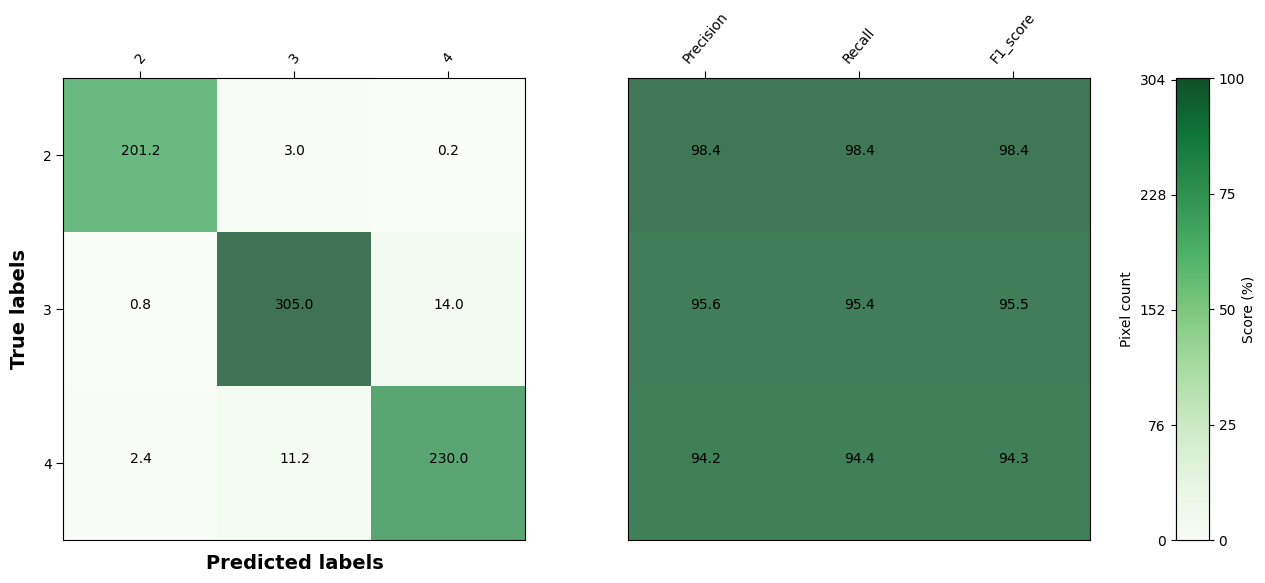

In [56]:
import plots

plots.plot_cm(mean_cm, np.unique(Y))
plt.savefig(sortie_matrix, bbox_inches='tight')
plt.show()


### Graphique qualité des classes

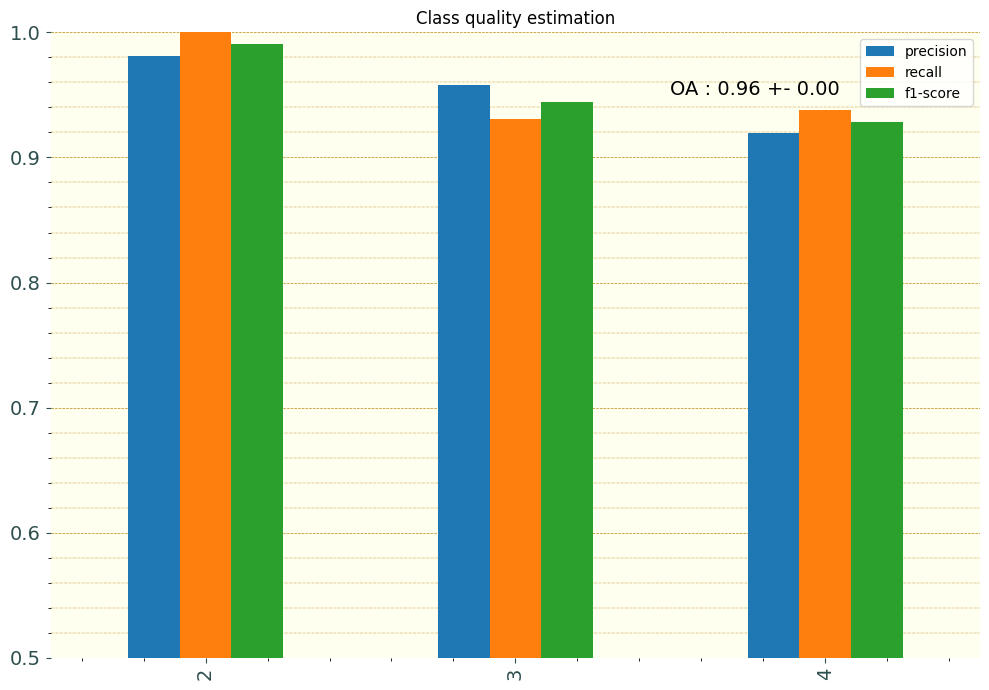

In [57]:
fig, ax = plt.subplots(figsize=(10, 7))

ax = mean_df_report.T.plot.bar(
    ax=ax,
    yerr=std_df_report.T,
    zorder=2
)

ax.set_ylim(0.5, 1)

ax.text(
    1.5, 0.95,
    'OA : {:.2f} +- {:.2f}'.format(mean_accuracy, std_accuracy),
    fontsize=14
)

ax.set_title('Class quality estimation')

# style
ax.set_facecolor('ivory')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)

ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--', linewidth=0.5)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.', linewidth=0.3)

plt.tight_layout()
plt.savefig(sortie_qualite, bbox_inches='tight')
plt.show()
